# Case Study AirBnB Prediction - Regression
This notebook walks through how to predict the real-value price of an AirBnB space in the AirBnB dataset

In [1]:
# Data Representation
import numpy as np
import pandas as pd

# Processing & Modeling
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# from sklearn import set_config
# set_config(display='diagram')   

import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.regressionplots import plot_partregress_grid, plot_regress_exog

random_state = 42
pd.set_option('display.max_rows', 100)

In [2]:
link = 'https://drive.google.com/file/d/1tT0lNiDHwGQPLa3N0zSdhZcJZaa5aqF3/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+link.split('/')[-2]

In [3]:
listings_df = pd.read_csv(path)
listings_df.set_index('id', inplace=True)
listings_df.head(1)

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [4]:
listings_df.head(1).T

id,241032
listing_url,https://www.airbnb.com/rooms/241032
scrape_id,20160104002432
last_scraped,2016-01-04
name,Stylish Queen Anne Apartment
summary,NaN
space,Make your self at home in this charming one-be...
description,Make your self at home in this charming one-be...
experiences_offered,none
neighborhood_overview,NaN
notes,NaN


In [5]:
columns_to_use = ["host_response_rate", "host_acceptance_rate", "host_is_superhost",                        "host_listings_count", "zipcode", "property_type","room_type",                            "accommodates","bathrooms", "bedrooms", "beds", "price",                                  "number_of_reviews", "review_scores_rating", "cancellation_policy", 
                  "reviews_per_month"]

In [6]:
listings_df = listings_df[columns_to_use]
listings_df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,
241032,96%,100%,f,3.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$85.00,207,95.0,moderate,4.07
953595,98%,100%,t,6.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,$150.00,43,96.0,strict,1.48
3308979,67%,100%,f,2.0,98119,House,Entire home/apt,11,4.5,5.0,7.0,$975.00,20,97.0,strict,1.15
7421966,NaN,NaN,f,1.0,98119,Apartment,Entire home/apt,3,1.0,0.0,2.0,$100.00,0,NaN,flexible,NaN
278830,100%,NaN,f,2.0,98119,House,Entire home/apt,6,2.0,3.0,3.0,$450.00,38,92.0,strict,0.89


In [7]:
listings_df.shape

(3818, 16)

In [8]:
# % of NaN values
missing_series = pd.Series(1 - listings_df.count() / len(listings_df))
missing_series

host_response_rate      0.136983
host_acceptance_rate    0.202462
host_is_superhost       0.000524
host_listings_count     0.000524
zipcode                 0.001833
property_type           0.000262
room_type               0.000000
accommodates            0.000000
bathrooms               0.004191
bedrooms                0.001572
beds                    0.000262
price                   0.000000
number_of_reviews       0.000000
review_scores_rating    0.169460
cancellation_policy     0.000000
reviews_per_month       0.164222
dtype: float64

In [9]:
listings_df.dtypes

host_response_rate       object
host_acceptance_rate     object
host_is_superhost        object
host_listings_count     float64
zipcode                  object
property_type            object
room_type                object
accommodates              int64
bathrooms               float64
bedrooms                float64
beds                    float64
price                    object
number_of_reviews         int64
review_scores_rating    float64
cancellation_policy      object
reviews_per_month       float64
dtype: object

In [10]:
listings_df['reviews_per_month'].value_counts()

1.00     70
2.00     45
0.23     24
0.81     21
0.36     21
         ..
4.16      1
6.35      1
12.15     1
9.38      1
5.56      1
Name: reviews_per_month, Length: 654, dtype: int64

## Clean & Preprocess Data

### Step 1: Clean Values Manually

In [11]:
listings_df['host_response_rate'] = listings_df['host_response_rate'].replace('[\%]',"",regex=True).astype(float)
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].replace('[\%]',"",regex=True).astype(float)
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].map({'t': 1, 'f': 0})
listings_df['price'] = listings_df['price'].replace('[\$\,]',"",regex=True).astype(float)

listings_df['accommodates'] = listings_df['accommodates'].astype(object)
listings_df['bathrooms'] = listings_df['bathrooms'].astype(object)
listings_df['bedrooms'] = listings_df['bedrooms'].astype(object)
listings_df['beds'] = listings_df['beds'].astype(object)

In [14]:
listings_df['host_acceptance_rate'].value_counts() # this imbalance is so great that this is not generally useful (i.e., this could represent an edge case).  I am going to discard this feature

100.0    3044
0.0         1
Name: host_acceptance_rate, dtype: int64

In [15]:
listings_df['bathrooms'].dtype

dtype('O')

In [17]:
listings_df.dtypes

host_response_rate      float64
host_acceptance_rate    float64
host_is_superhost       float64
host_listings_count     float64
zipcode                  object
property_type            object
room_type                object
accommodates             object
bathrooms                object
bedrooms                 object
beds                     object
price                   float64
number_of_reviews         int64
review_scores_rating    float64
cancellation_policy      object
reviews_per_month       float64
dtype: object

In [18]:
listings_df.shape

(3818, 16)

In [19]:
listings_y = listings_df.pop('price')
listings_X = listings_df.copy()

In [20]:
listings_y.head(1)

id
241032    85.0
Name: price, dtype: float64

In [21]:
listings_X.head(1)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,
241032,96.0,100.0,0.0,3.0,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,207,95.0,moderate,4.07


### Step 2: Handle Numerical Variables
- Scale Variables to Normal Distribution
- Impute Missing Data

> For the sake of today's workshop, we will assume that the following are the "numerical" variables:
\['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'review_scores_rating', 'reviews_per_month']

In [22]:
numerical_columns = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']

In [23]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),  
        ('standard_scaler', StandardScaler()),              
    ])
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standard_scaler', StandardScaler())])

In [24]:
listings_numerical_X = num_pipeline.fit_transform(listings_X[numerical_columns])

In [25]:
listings_X[numerical_columns].shape

(3818, 7)

In [26]:
listings_numerical_X.shape

(3818, 7)

### Step 3: Handle Categorical Variables
- Create Indicators (Dummies)
- Impute Missing Data

> For the sake of today's workshop, we will use the following as categorical features that need to be preprocessed: \['host_is_superhost', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'cancellation_policy']

In [27]:
categorical_columns = ['host_is_superhost', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'cancellation_policy']

In [28]:
cat_pipeline = Pipeline([
        ("cat", OneHotEncoder(handle_unknown='ignore')), 
        ('imputer', SimpleImputer(strategy="median")),            
    ])
cat_pipeline

Pipeline(steps=[('cat', OneHotEncoder(handle_unknown='ignore')),
                ('imputer', SimpleImputer(strategy='median'))])

In [29]:
listings_categorical_X = cat_pipeline.fit_transform(listings_X[categorical_columns])

In [30]:
listings_X[categorical_columns].shape

(3818, 9)

In [31]:
listings_categorical_X.shape

(3818, 104)

### Step 4: Compose Processing Pipeline for All Variables 

In [32]:
full_pipeline = ColumnTransformer([
        ("numerical", num_pipeline, numerical_columns),
        ("categorical", cat_pipeline, categorical_columns),
    ])

X_train_set_prepared = full_pipeline.fit_transform(listings_X)

In [33]:
X_train_set_prepared

<3818x111 sparse matrix of type '<class 'numpy.float64'>'
	with 61088 stored elements in Compressed Sparse Row format>

In [34]:
# diplays HTML representation in a jupyter context
full_pipeline  

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 ['host_response_rate', 'host_acceptance_rate',
                                  'host_is_superhost', 'host_listings_count',
                                  'number_of_reviews', 'review_scores_rating',
                                  'reviews_per_month']),
                                ('categorical',
                                 Pipeline(steps=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['host_is_superhost', 'zipcode',
                                  'property_type', 'room_type', 'accommodates',
                                  'bathrooms', 'bedrooms', 'beds',
                                  'cancellation_policy'])])

In [35]:
full_preprocesssing_pipeline = ColumnTransformer([
        ("numerical", num_pipeline, numerical_columns),
        ("categorical", cat_pipeline, categorical_columns),
    ])

X_train_set_prepared = full_preprocesssing_pipeline.fit_transform(listings_X)

## Prediction w/Regression

### Step 1: Split Data into Train and Test

In [36]:
# We are going to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(listings_X, listings_y, test_size=0.33, random_state=42)

In [37]:
f"The train set has {X_train.shape[0]} observations across {X_train.shape[1]} features used to predict prices ranging from {y_train.min()} to {y_train.max()}"

'The train set has 2558 observations across 15 features used to predict prices ranging from 20.0 to 1000.0'

In [38]:
f"The test set has {X_test.shape[0]} observations across the same {X_test.shape[1]} features used to test the fitted model in order to predict prices ranging from {y_test.min()} to {y_test.max()}"

'The test set has 1260 observations across the same 15 features used to test the fitted model in order to predict prices ranging from 26.0 to 775.0'

#### Step 2: Consider Performance Criteria

How will I know if the model performs well?

Three Common Criteria for Regression Based model  
1. Mean Squared Error (MSE)  
2. Root Mean Squared Error (RMSE)   
3. Mean Absolute Error (MAE)

#### Mean Squared Error (MSE)
- $MSE = \frac{1}{n} * \sum_{i=1}^{n}(y_i – \hat{y}_i)^2$
- A MSE of 0 is perfect, meaning all the predictions matched the true values exactly (and most likely your model has overfitted)
- Relative to a dataset

#### Root Mean Squared Error (RMSE)
- $RMSE = \sqrt{\frac{1}{n} * \sum_{i=1}^{n}(y_i – \hat{y}_i)^2}$
- The units of the RMSE are the same as the original units of the target value that is being predicted.
  + "For example, if your target variable has the units “dollars,” then the RMSE error score will also have the unit “dollars” and not “squared dollars” like the MSE." see [Regression Metrics for Machine Learning](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)


#### Mean Squared Error (MAE)
- $MAE = \frac{\sum_{i=1}^{n}|y_{i} – x_{i}|}{n}$
- The units of the error score match the units of the target value that is being predicted.
- changes in MAE are linear unlike with RMSE


### Statsmodels

In [39]:
X_train_transformed = full_preprocesssing_pipeline.fit_transform(X_train)

In [40]:
X_train_transformed.shape

(2558, 107)

In [41]:
ols_model = sm.OLS(y_train, X_train_transformed.todense())
fitted_ols_model = ols_model.fit()
fitted_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     42.49
Date:                Wed, 17 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:33:43   Log-Likelihood:                -13870.
No. Observations:                2558   AIC:                         2.793e+04
Df Residuals:                    2461   BIC:                         2.850e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7156      1.148      0.623      0.533      -1.535       2.967
const       1.384e-13   1.39e-13      0.997      0.319   -1.34e-13    4.11e-13
x2            17.6814      8.132      2.174      0.030       1.734      33.629
x3             1.0810      1.225      0.883      0.378      -1.321       3.483
x4            -0.3690      1.413     -0.261      0.794      -3.139       2.401
x5             3.0359      1.190      2.552      0.011       0.703       5.368
x6            -9.3027      1.440     -6.460      0.000     -12.126      -6.479
x7            76.1819     20.974      3.632      0.000      35.053     117.311
x8            40.2055      2.437     16.501      0.000      35.428      44.983
x9            52.7015     35.894      1.468      0.142     -17.684     123.087
x10           49.3817      5.888      8.386      0.000      37.835      60.928
x11           21.0090      4.544      4.624      0.000      12.099      29.919
x12            0.7489      4.257      0.176      0.860      -7.599       9.097
x13           50.6796      7.584      6.683      0.000      35.808      65.551
x14           -2.7154      5.181     -0.524      0.600     -12.876       7.445
x15          -25.4925      9.723     -2.622      0.009     -44.559      -6.426
x16            5.0251      5.615      0.895      0.371      -5.985      16.035
x17          -16.2629      9.250     -1.758      0.079     -34.401       1.875
x18           23.9867      5.645      4.249      0.000      12.918      35.056
x19           16.3898      5.834      2.809      0.005       4.949      27.831
x20           -2.0549      5.682     -0.362      0.718     -13.196       9.087
x21           13.3615      6.826      1.958      0.050      -0.023      26.746
x22           -7.1042      5.824     -1.220      0.223     -18.524       4.316
x23          -14.7013      5.931     -2.479      0.013     -26.332      -3.070
x24           32.5211      6.227      5.222      0.000      20.309      44.733
x25           36.2102      5.725      6.325      0.000      24.984      47.436
x26           11.6768      4.152      2.812      0.005       3.535      19.819
x27          -15.2349      8.208     -1.856      0.064     -31.330       0.860
x28           -2.7980      8.739     -0.320      0.749     -19.935      14.339
x29          -27.5730     10.819     -2.549      0.011     -48.788      -6.358
x30          105.5088     34.794      3.032      0.002      37.280     173.737
x31           -1.9849     10.629     -0.187      0.852     -22.827      18.858
x32          -12.5570      5.413     -2.320      0.020     -23.171      -1.943
x33          -14.4002     28.451     -0.506      0.613     -70.190      41.390
x34          -37.9135     14.760     -2.569      0.010     -66.857      -8.970
x35           -9.9273     28.236     -0.352      0.725     -65.296      45.441
x3

In [42]:
X_train_transformed.shape

(2558, 107)

In [43]:
# do NOT call fit_transform; only use .transform, because the pipeline has been fit to the training dataset
X_test_transformed = full_preprocesssing_pipeline.transform(X_test)

In [44]:
y_pred =  fitted_ols_model.predict(X_test_transformed.todense())

In [45]:
# Predicted Y Values (Price)
y_pred

array([ 61.10219167, 148.49997178,  77.0354996 , ...,  94.84480655,
       173.99907623,  99.86507596])

In [46]:
# Actual Y Values (Price)
y_test.values

array([ 55.,  82.,  68., ...,  80., 250., 100.])

In [47]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 3800.5503224888757
R^2: 0.5517068795950637


In [48]:
# fig = plt.figure(figsize=(12,8))
# fig = plot_regress_exog(fitted_ols_model, 'x1', fig=fig)

> Not great :( More work to do!

In [49]:
y_results = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test, 'residuals': y_pred-y_test})

In [50]:
px.scatter(y_results,
            x='y_pred',  
            y='y_test',
            title="Predicted vs. Actuals",
            labels=dict(y_pred="Predicted Prices ($)", y_test="Actual Prices ($)")
           )

In [51]:
px.scatter(y_results,
           x='y_pred',  
           y='residuals',
           title="Residuals as a Function of Predicted Values",
           labels=dict(y_pred="Predicted Prices ($)", residuals="Residuals ($)")
           )

### Scikit Learn

In [52]:
linear_regression = LinearRegression()
linear_regression_pipe = Pipeline([
            ("preprocessing", full_preprocesssing_pipeline),
            ("lr", linear_regression)
       ])
linear_regression_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_is_superhost',
                                                   'zipcode', 'property_type',
                                                   'room_type', 'accommodates',
                                                   'bathrooms', 'bedrooms',
                                                   'beds',
                                                   'cancellation_policy'])])),
                ('lr', LinearRegression())])

In [53]:
linear_regression_pipe.fit(X_train, y=y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_is_superhost',
                                                   'zipcode', 'property_type',
                                                   'room_type', 'accommodates',
                                                   'bathrooms', 'bedrooms',
                                                   'beds',
                                                   'cancellation_policy'])])),
                ('lr', LinearRegression())])

In [54]:
y_pred = linear_regression_pipe.predict(X_test)

In [55]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 3804.070920004558
R^2: 0.5512916082495809


## Prediction w/Random Forest Regressor

# TODO add plot of random forest

In [56]:
from sklearn.ensemble import RandomForestRegressor

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [57]:
random_forest = RandomForestRegressor(max_depth=2, random_state=random_state)
random_forest_pipe = Pipeline([
            ("preprocessing", full_preprocesssing_pipeline),
            ("rf", random_forest)
       ])
random_forest_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_is_superhost',
                                                   'zipcode', 'property_type',
                                                   'room_type', 'accommodates',
                                                   'bathrooms', 'bedrooms',
                                                   'beds',
                                                   'cancellation_policy'])])),
                ('rf', RandomForestRegressor(max_depth=2, random_state=42))])

In [58]:
random_forest_pipe.fit(X_train, y=y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_is_superhost',
                                                   'zipcode', 'property_type',
                                                   'room_type', 'accommodates',
                                                   'bathrooms', 'bedrooms',
                                                   'beds',
                                                   'cancellation_policy'])])),
                ('rf', RandomForestRegressor(max_depth=2, random_state=42))])

In [59]:
y_pred = random_forest_pipe.predict(X_test)

In [60]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 4644.445700283969
R^2: 0.4521653763636795


## Prediction w/Gradient Boosting Regressor

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

In [63]:
gradient_boosting = GradientBoostingRegressor(random_state=random_state)
gradient_boosting_pipe = Pipeline([
            ("preprocessing", full_preprocesssing_pipeline),
            ("gb", gradient_boosting)
       ])
gradient_boosting_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_is_superhost',
                                                   'zipcode', 'property_type',
                                                   'room_type', 'accommodates',
                                                   'bathrooms', 'bedrooms',
                                                   'beds',
                                                   'cancellation_policy'])])),
                ('gb', GradientBoostingRegressor(random_state=42))])

In [64]:
gradient_boosting_pipe.fit(X_train, y=y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_is_superhost',
                                                   'zipcode', 'property_type',
                                                   'room_type', 'accommodates',
                                                   'bathrooms', 'bedrooms',
                                                   'beds',
                                                   'cancellation_policy'])])),
                ('gb', GradientBoostingRegressor(random_state=42))])

In [65]:
y_pred = gradient_boosting_pipe.predict(X_test)

In [66]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 3469.569419417117
R^2: 0.5907476629664873


## Prediction w/Ensemble Voting

In [67]:
voting_model = VotingRegressor([
    ('linear_regression', linear_regression_pipe), 
    ('random_forest', random_forest_pipe), 
    ('gradient_boosting', gradient_boosting_pipe)]
)
voting_model

VotingRegressor(estimators=[('linear_regression',
                             Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standard_scaler',
                                                                                                StandardScaler())]),
                                                                               ['host_response_rate',
                                                                                'host_acceptance_rate',
                                                                                'host_is_superhost',
                                                                                'host_listings_count',
                                                                                'number_of_reviews',
                                                                                'review_scores_r...
                                                                                'review_scores_rating',
                                                                                'reviews_per_month']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('cat',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['host_is_superhost',
                                                                                'zipcode',
                                                                                'property_type',
                                                                                'room_type',
                                                                                'accommodates',
                                                                                'bathrooms',
                                                                                'bedrooms',
                                                                                'beds',
                                                                                'cancellation_policy'])])),
                                             ('gb',
                                              GradientBoostingRegressor(random_state=42))]))])

In [68]:
voting_model.fit(X_train, y=y_train)

VotingRegressor(estimators=[('linear_regression',
                             Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standard_scaler',
                                                                                                StandardScaler())]),
                                                                               ['host_response_rate',
                                                                                'host_acceptance_rate',
                                                                                'host_is_superhost',
                                                                                'host_listings_count',
                                                                                'number_of_reviews',
                                                                                'review_scores_r...
                                                                                'review_scores_rating',
                                                                                'reviews_per_month']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('cat',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['host_is_superhost',
                                                                                'zipcode',
                                                                                'property_type',
                                                                                'room_type',
                                                                                'accommodates',
                                                                                'bathrooms',
                                                                                'bedrooms',
                                                                                'beds',
                                                                                'cancellation_policy'])])),
                                             ('gb',
                                              GradientBoostingRegressor(random_state=42))]))])

In [69]:
# Now let's look to see how each model performed

y_pred_1 = linear_regression_pipe.predict(X_test) # linear regression
y_pred_2 = random_forest_pipe.predict(X_test) # random forest
y_pred_3 = gradient_boosting_pipe.predict(X_test) # gradient boost
y_pred_4 = voting_model.predict(X_test) # voting regression

In [70]:
y_test.values

array([ 55.,  82.,  68., ...,  80., 250., 100.])

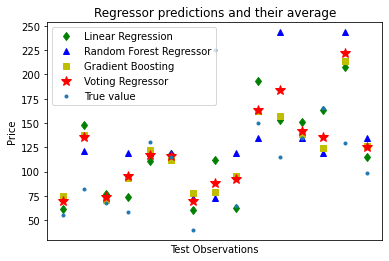

In [71]:
view_n = 15
plt.figure()
plt.plot(y_pred_1[:view_n], 'gd', label='Linear Regression')
plt.plot(y_pred_2[:view_n], 'b^', label='Random Forest Regressor')
plt.plot(y_pred_3[:view_n], 'ys', label='Gradient Boosting')
plt.plot(y_pred_4[:view_n], 'r*', ms=10, label='Voting Regressor')
plt.plot(y_test.values[:view_n], '.', label="True value")

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Price')
plt.xlabel('Test Observations')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

In [72]:
print(f"MSE: {mean_squared_error(y_test, y_pred_4)}")
print(f"R^2: {r2_score(y_test, y_pred_4)}")

MSE: 3502.810138755563
R^2: 0.5868267608517173


## Tuning Parameters w/Grid Search on Gradient B
See: [Using the prediction pipeline in a grid search](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#using-the-prediction-pipeline-in-a-grid-search)

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
gradient_boosting = GradientBoostingRegressor(random_state=random_state)
gradient_boosting_pipe = Pipeline([
            ("preprocessor", full_preprocesssing_pipeline),
            ("classifier", gradient_boosting)
       ])
gradient_boosting_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['host_is_superhost',
                                                   'zipcode', 'property_type',
                                                   'room_type', 'accommodates',
                                                   'bathrooms', 'bedrooms',
                                                   'beds',
                                                   'cancellation_policy'])])),
                ('classifier', GradientBoostingRegressor(random_state=42))])

In [75]:
param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'],
    'classifier__alpha': [1e0, 1e-1, 1e-2, 1e-3],
}

optimized_gradient_boost_model = GridSearchCV(gradient_boosting_pipe, param_grid, cv=10)
optimized_gradient_boost_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standard_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'number_of_reviews',
                                                                          'review_scores_rating',
                                                                          'reviews_per_m...
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['host_is_superhost',
                                                                          'zipcode',
                                                                          'property_type',
                                                                          'room_type',
                                                                          'accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'cancellation_policy'])])),
                                       ('classifier',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'classifier__alpha': [1.0, 0.1, 0.01, 0.001],
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median']})

In [76]:
optimized_gradient_boost_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standard_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'number_of_reviews',
                                                                          'review_scores_rating',
                                                                          'reviews_per_m...
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['host_is_superhost',
                                                                          'zipcode',
                                                                          'property_type',
                                                                          'room_type',
                                                                          'accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'cancellation_policy'])])),
                                       ('classifier',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'classifier__alpha': [1.0, 0.1, 0.01, 0.001],
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median']})

In [77]:
y_pred = optimized_gradient_boost_model.predict(X_test)

In [78]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 3469.569419417117
R^2: 0.5907476629664873


In [79]:
optimized_gradient_boost_model.best_params_

{'classifier__alpha': 0.1,
 'preprocessor__numerical__imputer__strategy': 'median'}